In [1]:
## https://github.com/golbin/TensorFlow-Tutorials/
## TensorFlow-Tutorials/04 - Neural Network Basic/03 - Word2Vec.py

# Word2Vec 모델을 간단하게 구현해봅니다.
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [0]:
# 단어 벡터를 분석해볼 텍스트 (어린왕자)
f = open("thelittleprince.txt", 'r', encoding='utf8')
sentences = f.readlines()
f.close()

In [0]:
# 문장을 전부 합친 후 공백으로 단어들을 나누고 고유한 단어들로 리스트를 만듭니다.
word_sequence = " ".join(sentences).split()
word_list = " ".join(sentences).split()
word_list = list(set(word_list))
# 문자열로 분석하는 것 보다, 숫자로 분석하는 것이 훨씬 용이하므로
# 리스트에서 문자들의 인덱스를 뽑아서 사용하기 위해,
# 이를 표현하기 위한 연관 배열과, 단어 리스트에서 단어를 참조 할 수 있는 인덱스 배열을 만듭합니다.
word_dict = {w: i for i, w in enumerate(word_list)}

In [0]:
# 윈도우 사이즈를 1 로 하는 skip-gram 모델을 만듭니다.
skip_grams = []

for i in range(1, len(word_sequence) - 1):
	# (context, target) : ([target index - 1, target index + 1], target)
	# 스킵그램을 만든 후, 저장은 단어의 고유 번호(index)로 저장합니다
	target = word_dict[word_sequence[i]]
	context = [word_dict[word_sequence[i - 1]], word_dict[word_sequence[i + 1]]]

	# (target, context[0]), (target, context[1])..
	for w in context:
		skip_grams.append([target, w])

In [0]:
# skip-gram 데이터에서 무작위로 데이터를 뽑아 입력값과 출력값의 배치 데이터를 생성하는 함수
def random_batch(data, size):
	random_inputs = []
	random_labels = []
	random_index = np.random.choice(range(len(data)), size, replace=False)

	for i in random_index:
		random_inputs.append(data[i][0])  # target
		random_labels.append([data[i][1]])  # context word

	return random_inputs, random_labels

In [0]:
#########
# 옵션 설정
######
# 학습을 반복할 횟수
training_epoch = 300
# 학습률
learning_rate = 0.1
# 한 번에 학습할 데이터의 크기
batch_size = 20
# 단어 벡터를 구성할 임베딩 차원의 크기
# 이 예제에서는 x, y 그래프로 표현하기 쉽게 2 개의 값만 출력하도록 합니다.
embedding_size = 2
# word2vec 모델을 학습시키기 위한 nce_loss 함수에서 사용하기 위한 샘플링 크기
# batch_size 보다 작아야 합니다.
num_sampled = 15
# 총 단어 갯수
voc_size = len(word_list)

In [0]:
#########
# 신경망 모델 구성
######
inputs = tf.placeholder(tf.int32, shape=[batch_size])
# tf.nn.nce_loss 를 사용하려면 출력값을 이렇게 [batch_size, 1] 구성해야합니다.
labels = tf.placeholder(tf.int32, shape=[batch_size, 1])

In [0]:
# word2vec 모델의 결과 값인 임베딩 벡터를 저장할 변수입니다.
# 총 단어 갯수와 임베딩 갯수를 크기로 하는 두 개의 차원을 갖습니다.
embeddings = tf.Variable(tf.random_uniform([voc_size, embedding_size], -1.0, 1.0))
# 임베딩 벡터의 차원에서 학습할 입력값에 대한 행들을 뽑아옵니다.
# 예) embeddings	 inputs	selected
#	[[1, 2, 3]  -> [2, 3] -> [[2, 3, 4]
#	 [2, 3, 4]				[3, 4, 5]]
#	 [3, 4, 5]
#	 [4, 5, 6]]
selected_embed = tf.nn.embedding_lookup(embeddings, inputs)

In [0]:
# nce_loss 함수에서 사용할 변수들을 정의합니다.
nce_weights = tf.Variable(tf.random_uniform([voc_size, embedding_size], -1.0, 1.0))
nce_biases = tf.Variable(tf.zeros([voc_size]))

In [10]:
# nce_loss 함수를 직접 구현하려면 매우 복잡하지만,
# 함수를 텐서플로우가 제공하므로 그냥 tf.nn.nce_loss 함수를 사용하기만 하면 됩니다.
loss = tf.reduce_mean(
			tf.nn.nce_loss(nce_weights, nce_biases, labels, selected_embed, num_sampled, voc_size))

train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [11]:
#########
# 신경망 모델 학습
######
with tf.Session() as sess:
	init = tf.global_variables_initializer()
	sess.run(init)

	for step in range(1, training_epoch + 1):
		batch_inputs, batch_labels = random_batch(skip_grams, batch_size)

		_, loss_val = sess.run([train_op, loss],
							   feed_dict={inputs: batch_inputs,
										  labels: batch_labels})

		if step % 10 == 0:
			print("loss at step ", step, ": ", loss_val)

	# matplot 으로 출력하여 시각적으로 확인해보기 위해
	# 임베딩 벡터의 결과 값을 계산하여 저장합니다.
	# with 구문 안에서는 sess.run 대신 간단히 eval() 함수를 사용할 수 있습니다.
	trained_embeddings = embeddings.eval()

loss at step  10 :  49.405037
loss at step  20 :  58.37329
loss at step  30 :  46.615486
loss at step  40 :  59.73878
loss at step  50 :  29.084192
loss at step  60 :  33.36245
loss at step  70 :  36.93526
loss at step  80 :  32.15532
loss at step  90 :  41.673004
loss at step  100 :  27.218441
loss at step  110 :  39.194214
loss at step  120 :  30.215527
loss at step  130 :  27.30686
loss at step  140 :  17.681149
loss at step  150 :  29.930878
loss at step  160 :  12.0523
loss at step  170 :  35.64422
loss at step  180 :  24.867733
loss at step  190 :  35.697266
loss at step  200 :  40.207832
loss at step  210 :  38.44529
loss at step  220 :  22.432825
loss at step  230 :  12.304657
loss at step  240 :  13.01327
loss at step  250 :  31.661575
loss at step  260 :  27.047647
loss at step  270 :  13.974536
loss at step  280 :  31.707748
loss at step  290 :  17.78778
loss at step  300 :  26.619867


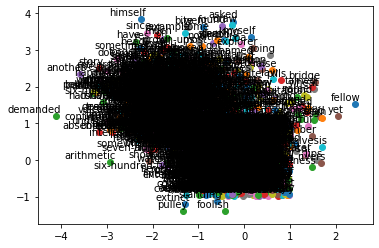

In [12]:
#########
# 임베딩된 Word2Vec 결과 확인
# 결과는 해당 단어들이 얼마나 다른 단어와 인접해 있는지를 보여줍니다.
######
for i, label in enumerate(word_list):
	x, y = trained_embeddings[i]
	plt.scatter(x, y)
	plt.annotate(label, xy=(x, y), xytext=(5, 2),
				 textcoords='offset points', ha='right', va='bottom')

plt.show()